In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio
import statistics
import cv2
from PIL import Image

In [5]:
def load_json(group,student):
    with open(f'./data/all_json/{group}_{student}.json') as f:
        return json.load(f)
    
def load_images(group,student):
    #return imageio.imread(f'./data/sequences/{group}-{student}.tif')
    return imageio.imread(f'../../{group}-{student}.nosync.tif')

In [6]:
#data = load_json(1,1)
images = load_images(9,3)

In [7]:
def show_image(group,student,frame, energy= None, threshold = None):
    plt.figure(figsize=(15,10))
    data = load_json(group,student)
    images = load_images(group,student)
    plt.imshow(images[frame-1])
    data = data['{}_{}_frame_{}'.format(group,student,frame)]
    for d in data["boxes"]:
        rect = plt.Rectangle((d[0], d[1]), d[2], d[3], fill=False, color='red')
        plt.gca().add_patch(rect)
    
    for d in data["cells"]:
        plt.plot(d[0], d[1], 'ro', markersize=2)

    if energy is not None and threshold is not None:
        for i , e in enumerate(energy):
            if e <threshold:
                plt.axvline(x=i, color='red')    
    plt.show()



In [8]:
background = np.zeros((10,images.shape[1],images.shape[2]))
images_mean = np.mean(images,axis=3)
background[0] = np.mean(images_mean[:1],axis=(0))

for i in range(1,10):
    background[i] = np.mean(images_mean[:10*i],axis=(0))


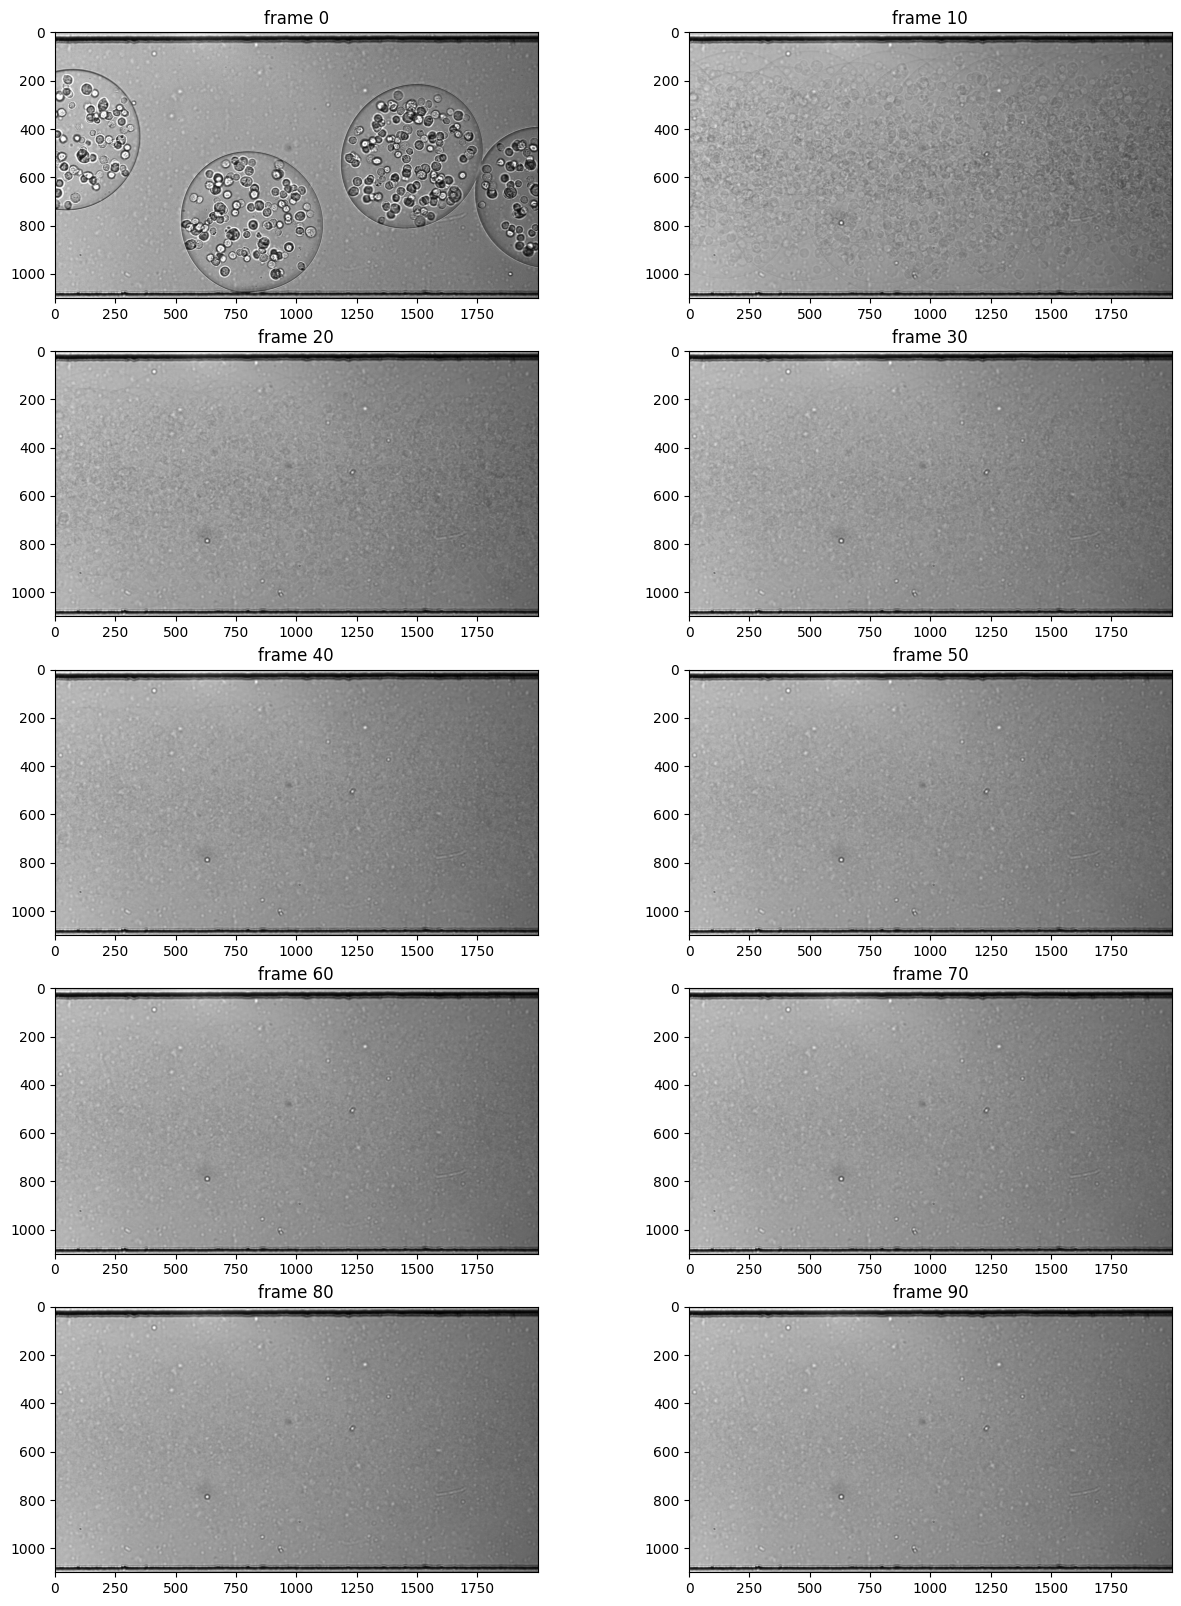

In [10]:
fig, axs = plt.subplots(5,2, figsize=(15,20))
for i in range(10):
    axs[i//2,i%2].imshow(background[i], cmap='gray')
    axs[i//2,i%2].set_title(f'frame {i*10}')
plt.show()

In [11]:
def column_energy_one(column):
    return np.sum(np.diff(column)**2)

In [12]:
def column_energy_integrated(column, previous = 1):
    energy = 0
    for i in range(previous):
        rolling = np.roll(column, 1)
        energy += np.sum(np.subtract(column,rolling)**2)
    return energy

In [13]:
def column_energy_var(column):
    return statistics.variance(column)

In [10]:
# Energy of each column
nb_samples = 100
square_diff = []
indexes_square = []
images_sample = images_mean[0:nb_samples]
for index, image in enumerate(images_sample):
    for col in range(image.shape[1]):
        energy = column_energy_one(image[:,col])
        if index == 0:
            square_diff.append(energy)
            indexes_square.append(0)
        else:
            if square_diff[col] > energy:
                square_diff[col] = energy
                indexes_square[col] = index

In [11]:
# Background creation
background_energy = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_energy.shape)[0]):
    for j in range((background_energy.shape)[1]):
        background_energy[i][j][:] = images_sample[indexes_square[j],i,j]

In [92]:
# Variance of each column
nb_samples = 10
var_diff = []
indexes_var = []
images_sample = images_mean[0:nb_samples]
for index, image in enumerate(images_sample):
    for col in range(image.shape[1]):
        var = column_energy_var(image[:,col])
        if index == 0:
            var_diff.append(var)
            indexes_var.append(0)
        else:
            if var_diff[col] < var:
                var_diff[col] = var
                indexes_var[col] = index
    print(index)

0


In [93]:
# Background creation
background_var = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_var.shape)[0]):
    for j in range((background_var.shape)[1]):
        background_var[i][j][:] = images_sample[indexes_var[j],i,j]

In [12]:
# Energy image
img = Image.fromarray(background_energy, 'RGB')
img.show()

In [94]:
# Variance image
img = Image.fromarray(background_var, 'RGB')
img.show()

In [111]:
# Energy integrated of each column
nb_samples = 100
square_diff = []
indexes_square_int = []
images_sample = images_mean[0:nb_samples]
for index, image in enumerate(images_sample):
    for col in range(image.shape[1]):
        energy = column_energy_integrated(image[:,col], previous=10)
        if index == 0:
            square_diff.append(energy)
            indexes_square_int.append(0)
        else:
            if square_diff[col] > energy:
                square_diff[col] = energy
                indexes_square_int[col] = index

# Background creation
background_energy = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_energy.shape)[0]):
    for j in range((background_energy.shape)[1]):
        background_energy[i][j][:] = images_sample[indexes_square_int[j],i,j]

# Energy image
img = Image.fromarray(background_energy, 'RGB')
img.show()

In [123]:
# Test difference between integrated and one
nb = 0
for i in range(len(indexes_square_int)):
    if indexes_square_int[i] != indexes_square[i]:
        nb += 1
print(nb)

1764


In [13]:
def column_energy_integrated_2d(array, previous = 1):
    energy = 0
    for i in range(previous):
        mid_col = array[:,previous]
        rolling = np.roll(mid_col, 1)
        energy += np.sum(np.subtract(mid_col,rolling)**2)
    for k in range(array.shape[0]):
        row = array[k,:]
        for j in range(2*previous):
            rolling = np.roll(row, j-previous)
            energy += np.sum(np.subtract(row,rolling)**2)
    return energy


In [24]:
def convolve_2D(array,filter):
    fx = filter.shape[0]
    fy = filter.shape[1]
    result = np.zeros((array.shape[0],array.shape[1]))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if i>=fx//2 and i+fx//2+1 < array.shape[0] and j>=fy//2 and j+fy//2+1 < array.shape[1]:
                #result[i,j] = np.sum(np.multiply(array[i-fx//2:i+fx//2+1,j-fy//2:j+fy//2+1],filter))
                result[i,j] = np.sum((np.multiply(array[i-fx//2:i+fx//2+1,j-fy//2:j+fy//2+1],filter) + array[i,j])**2)
            else:
                sfx = 0
                efx = fx
                if i>=fx//2:
                    startx = i-fx//2 
                else: 
                    startx = 0
                    sfx += fx//2-i
                if i+fx//2+1 < array.shape[0]:
                    endx = i+fx//2+1
                else:
                    endx = array.shape[0]
                    efx -= i+fx//2+1-array.shape[0]
                sfy = 0
                efy = fy
                if j>=fy//2:
                    starty = j-fy//2 
                else: 
                    starty = 0
                    sfy += fy//2-j
                if j+fy//2+1 < array.shape[1]:
                    endy = j+fy//2+1
                else:
                    endy = array.shape[1]
                    efy -= j+fy//2+1-array.shape[1]

                #result[i,j] = np.sum(np.multiply(array[startx:endx,starty:endy],filter[sfx:efx,sfy:efy]))
                result[i,j] = np.sum((np.multiply(array[startx:endx,starty:endy],filter[sfx:efx,sfy:efy]) + array[i,j])**2)
    return result

In [23]:
def column_energy_integrated_2d_bis(image, previous = 1):
    filter = np.ones((2*previous+1,2*previous+1))*-1
    #filter[previous][previous] = previous**2-1
    filter[previous][previous] = 0
    filtered_image = convolve_2D(image, filter)
    return np.sum(filtered_image, axis=0)

In [27]:
# 2D energy
# Energy integrated of each column
nb_samples = 30
square_diff_2d = []
indexes_square_2d = []
images_sample = images_mean[0:nb_samples]
for index, image in enumerate(images_sample):
    energy = column_energy_integrated_2d_bis(image, previous=2)
    print(energy)
    for col in range(image.shape[1]):
        if index == 0:
            square_diff_2d.append(energy[col])
            indexes_square_2d.append(0)
        else:
            if square_diff_2d[col] > energy[col]:
                square_diff_2d[col] = energy[col]
                indexes_square_2d[col] = index
    print(index)

# Background creation
background_energy = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_energy.shape)[0]):
    for j in range((background_energy.shape)[1]):
        background_energy[i][j][:] = images_sample[indexes_square_2d[j],i,j]

# Energy image
img = Image.fromarray(background_energy, 'RGB')
img.show()

[42385853. 44818199. 49281843. ... 18759154. 16546879. 15125508.]
0
[37870149. 38436970. 41157553. ... 18488013. 16777174. 15538205.]
1
[44039490. 47857690. 55138683. ... 25982078. 22496765. 20451094.]
2
[42249440. 43994585. 47601772. ... 13791158. 13643411. 13433764.]
3
[43353217. 46201473. 51602387. ... 21176522. 18982919. 17785148.]
4
[43123137. 45482074. 50275596. ... 14307135. 13789150. 13426098.]
5
[42570836. 44512863. 49203192. ... 23922385. 21003921. 18905036.]
6
[37840108. 38635706. 39796230. ... 15534401. 14463641. 13916331.]
7
[40909264. 42488895. 45697834. ... 27085331. 22691361. 20168646.]
8
[39581121. 40698204. 42696038. ... 19504615. 18060743. 17006804.]
9
[43433537. 45504715. 49452793. ... 22182086. 20082096. 18899387.]
10
[43240005. 45501493. 49588139. ... 14871702. 14024219. 13363451.]
11
[45765449. 49771861. 56920610. ... 23896220. 20609556. 18610627.]
12
[37646668. 38560073. 41568749. ... 17081131. 15724952. 15699863.]
13
[41936408. 44778657. 50787752. ... 14387459.

In [105]:
# Cut by mean
nb_samples = 10
indexes = []
images_mean = np.mean(images,axis=3)
images_nobound = images_mean[:nb_samples,100:-80,:]
keep = True
index = 0

In [74]:
indexes = []
counter = 0
for col in range(images_nobound.shape[2]):
    keep = True
    index = 0
    for nb, image in enumerate(images_nobound):
        for row in range(image.shape[0]):
            if image[row,col] < 50:
                keep = False
                counter += 1
                break
        if keep:
            index = nb
    indexes.append(index)

print(counter)
# Background creation
background_energy = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_energy.shape)[0]):
    for j in range((background_energy.shape)[1]):
        background_energy[i][j][:] = images_sample[indexes[j],i,j]

# Energy image
img = Image.fromarray(background_energy, 'RGB')
img.show()        

14876


In [14]:
# Cut by mean
nb_samples = 20
indexes = []
images_mean = np.mean(images,axis=3)
images_nobound = images_mean[:nb_samples,100:-80,:]
keep = True
index = 0

In [15]:
mean = np.mean(images_nobound)
images_test = (images_nobound - mean)**4
column_mean = np.mean(images_test, axis=1)
indexes = []

for i in range(column_mean.shape[1]):
    indexes.append(list(zip(*np.where(column_mean[:,i]==min(column_mean[:,i])))))

In [16]:
# Background creation
background_energy = np.zeros((images.shape[1],images.shape[2],3),dtype=np.uint8)
for i in range((background_energy.shape)[0]):
    for j in range((background_energy.shape)[1]):
        background_energy[i][j][:] = images_mean[int(indexes[j][0][0]),i,j]

# Energy image
img = Image.fromarray(background_energy, 'RGB')
img.show()  

In [20]:
# blur the image
blur = cv2.blur(background_energy,(5,5))
img = Image.fromarray(blur, 'RGB')
img.show()  
kernel3 = np.array([[0, -1,  0],
                   [-1,  5, -1],
                    [0, -1,  0]])
sharp_img = cv2.filter2D(src=blur, ddepth=-1, kernel=kernel3)
img = Image.fromarray(sharp_img, 'RGB')
img.show() 

In [40]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
B = np.array([[1,5,2],[3,7,5],[1,10,0]])
mask = np.zeros((3,3))
mask[A>B] = 1
print(mask)

[[0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]]


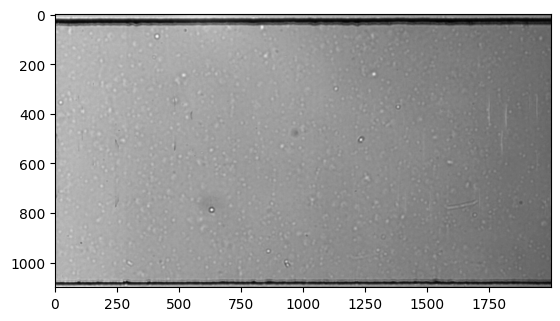

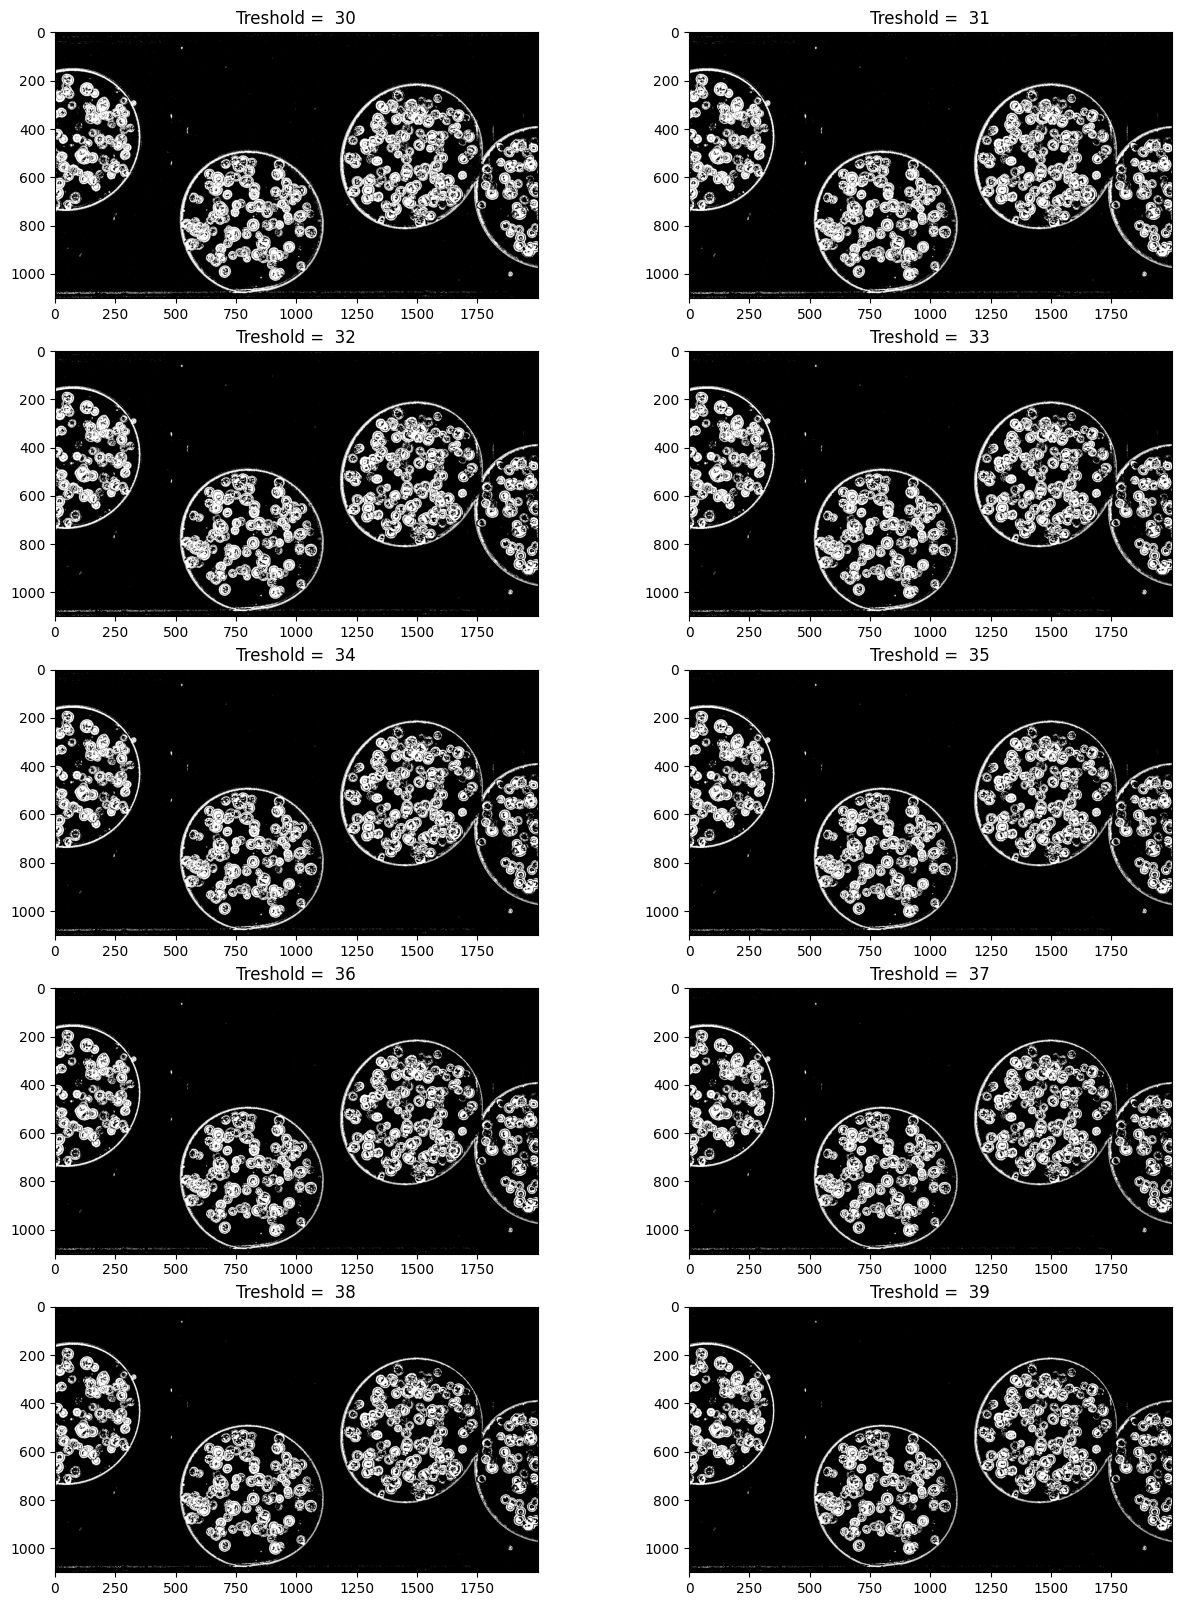

In [48]:
back = np.mean(blur,axis = 2)
plt.imshow(back, cmap='gray')

im = images[0]
im = np.mean(im,axis=2)

def get_mask(im,back,threshold=1):
    mask = np.zeros(im.shape)
    mask[threshold < abs(back-im)] = 1
    return mask

masks = np.zeros((10,im.shape[0],im.shape[1]))
for i in range(10):
    masks[i] = get_mask(im,back,threshold=1*i+30)

fig, axs = plt.subplots(5,2, figsize=(15,20))
for i in range(10):
    axs[i//2,i%2].imshow(masks[i], cmap='gray')
    axs[i//2,i%2].set_title(f'Treshold =  {1*i+30}')